<a href="https://colab.research.google.com/github/Fat-AK/TeachingTensorflow2022/blob/main/Loss_Surfaces_in_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

#Data
def prepare_mnist_data(mnist):
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  
  #Dont batch, dont prefetch
  #mnist = mnist.batch(32)
  #mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)


#Model
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.out(x)
        return x
    
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.out(x)
        return x
    


#Training
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset.take(320).batch(32), cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset.take(320).batch(32), cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs. NOTICE WE DO THIS ONLY ON A TINY FRACTION OF THE DATA!
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    #ONLY TAKING A TINY FRACTION OF THE DATA!
    epoch_loss_agg = []
    for input,target in train_dataset.shuffle(40000).take(320).batch(32):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset.take(320).batch(32), cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch: 0 starting with accuracy 0.0875
Epoch: 1 starting with accuracy 0.109375
Epoch: 2 starting with accuracy 0.165625
Epoch: 3 starting with accuracy 0.18125
Epoch: 4 starting with accuracy 0.2125
Epoch: 5 starting with accuracy 0.25
Epoch: 6 starting with accuracy 0.2875
Epoch: 7 starting with accuracy 0.25625
Epoch: 8 starting with accuracy 0.275
Epoch: 9 starting with accuracy 0.359375


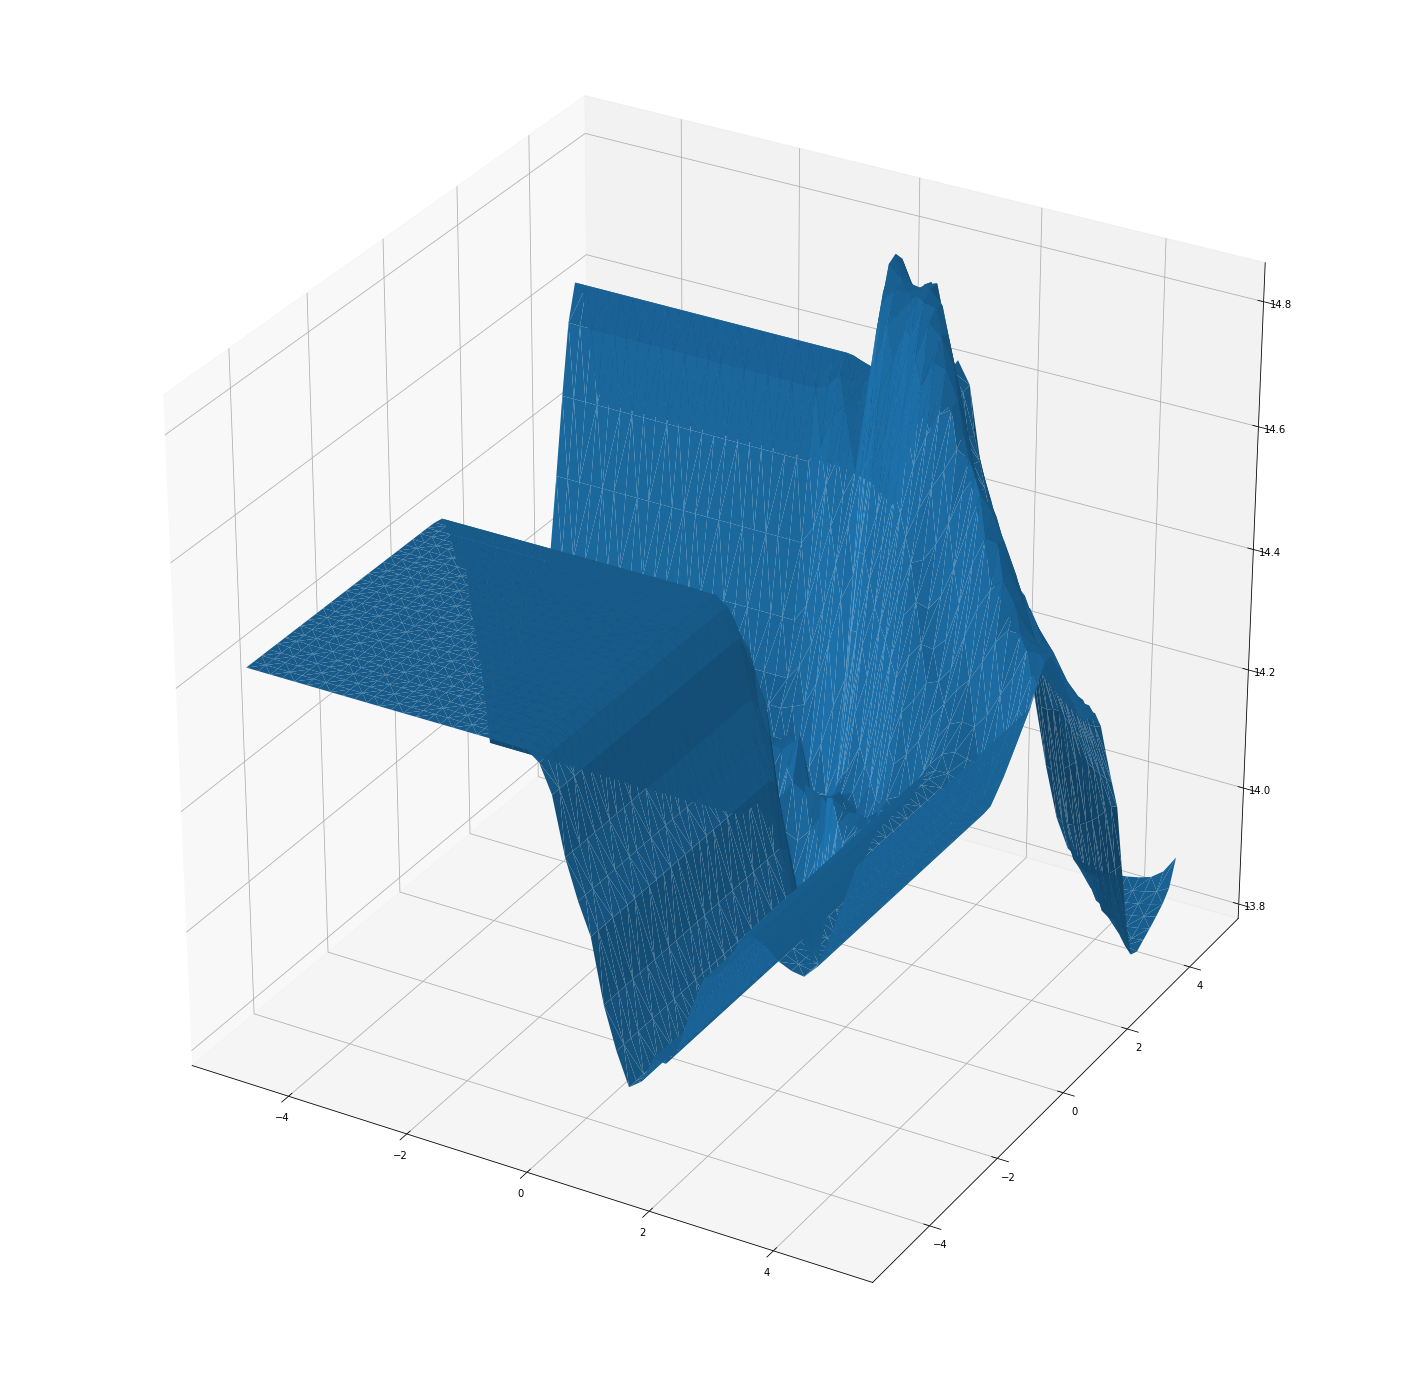

In [ ]:
#3d error plot

import numpy as np
import matplotlib.pyplot as plt

data, _ = tf.keras.datasets.mnist.load_data() # list of input, target pairs from dataset
sample_size = 100



#choose two random weights from a layer
layer_idx = 2
random_weight_idx_1 = [45,7]
random_weight_idx_2 = [45,87]
w1_org_val = model.trainable_variables[layer_idx].numpy()[random_weight_idx_1[0], random_weight_idx_1[1]]
w2_org_val = model.trainable_variables[layer_idx].numpy()[random_weight_idx_2[0], random_weight_idx_2[1]]

#get a sample from the data
input = data[0][0:sample_size]
target = data[1][0:sample_size]
input = np.reshape(input, (sample_size,-1))
target = np.reshape(target, (sample_size))
target = tf.one_hot(target, depth=10)

#aoi is area of interest
aoi = [i/100 for i in range(-500,500,20)]
org_val = model.trainable_variables[layer_idx].numpy()

i_agg = [] #index in first weight matrix dimension
j_agg = [] #index in second weight matrix dimension
loss_agg = []
for w1_change in aoi:
  for w2_change in aoi:
    #changes applied to weight matrix
    delta = np.zeros(model.trainable_variables[layer_idx].shape)
    delta[random_weight_idx_1[0],random_weight_idx_1[1]] = w1_change + w1_org_val
    delta[random_weight_idx_2[0],random_weight_idx_2[1]] = w2_change + w2_org_val
    model.trainable_variables[layer_idx].assign_add(delta)

    #see what model does with changed weights
    pred = model(input)
    loss = cross_entropy_loss(target, pred)

    #log the results
    model.trainable_variables[layer_idx].assign(org_val)
    i_agg.append(w1_change + w1_org_val)
    j_agg.append(w2_change + w2_org_val)
    loss_agg.append(loss)


fig = plt.figure(figsize=(25,25))
ax = fig.gca(projection='3d')

ax.plot_trisurf(i_agg, j_agg, loss_agg, linewidth=0.001)

plt.show()

[<tf.Tensor: shape=(), dtype=float32, numpy=13.9916935>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991697>, <tf.Tensor: shape=(), dtype=float32, numpy=13.9917>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991704>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991708>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991711>, <tf.Tensor: shape=(), dtype=float32, numpy=13.9917145>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991718>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991722>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991726>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991729>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991733>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991736>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991739>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991743>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991746>, <tf.Tensor: shape=(), dtype=float32, numpy=13.99175>, <tf.Tensor: shape=(), dtype=float32, numpy=13.991754>, <tf.Tensor

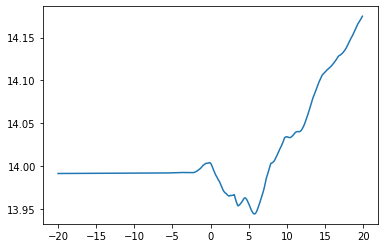

In [ ]:
#2d error plot

import numpy as np

#weight/unit we are analyzing
weight_layer = 2
random_weight_idx = [5,41]
sample_size = 1000

#aoi = area of interest
aoi = [i/100 for i in range(-2000,2000,10)]
#
org_val = model.trainable_variables[2].numpy()
input = data[0][0:sample_size]
target = data[1][0:sample_size]
input = np.reshape(input, (sample_size,-1))
target = np.reshape(target, (sample_size))
target = tf.one_hot(target, depth=10)
i_2d_agg = []
loss_2d_agg = []
for i in aoi:
  delta = np.zeros(model.trainable_variables[weight_layer].shape)
  delta[random_weight_idx[0],random_weight_idx[1]] = i
  model.trainable_variables[weight_layer].assign_add(delta)
  pred = model(input)
  loss = cross_entropy_loss(target, pred)
  model.trainable_variables[weight_layer].assign(org_val)
  i_2d_agg.append(i)
  loss_2d_agg.append(loss)
  
plt.plot(i_2d_agg, loss_2d_agg)
print(loss_2d_agg)

<Figure size 432x288 with 0 Axes>

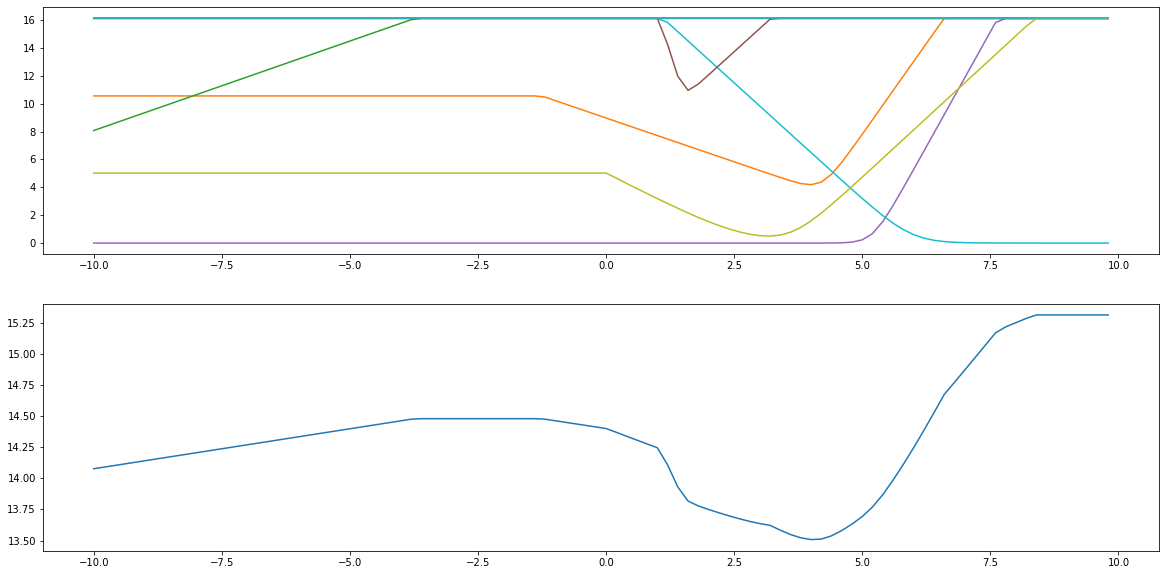

In [ ]:
#What layer/unit are we analyzing
layer = 2
w_idx_1 = 23
w_idx_2 = 5

loss_agg = []
batch_size = 1

plt.clf()
plt.figure(figsize=(20,10))
plt.subplot(211)
num_rand_samples = 20
for rand_sample in range(num_rand_samples):


  aoi = [i/100 for i in range(-1000,1000,20)]
  org_val = model.trainable_variables[layer].numpy()

  datapoint = np.random.randint(0,500)

  input = data[0][datapoint]
  target = data[1][datapoint]
  input = np.reshape(input, (batch_size,-1))
  target = np.reshape(target, (batch_size))
  target = tf.one_hot(target, depth=10)
  i_2d_agg = []
  loss_2d_agg = []

  for i in aoi:
    delta = np.zeros(model.trainable_variables[layer].shape)
    delta[w_idx_1, w_idx_2] = i
    model.trainable_variables[layer].assign_add(delta)
    pred = model(input)
    loss = cross_entropy_loss(target, pred)
    model.trainable_variables[layer].assign(org_val)
    i_2d_agg.append(i)
    loss_2d_agg.append(loss)
    loss_agg.append(loss_2d_agg)
  
  plt.plot(i_2d_agg, loss_2d_agg)

plt.subplot(212)

mean_surface = [np.mean([sublist[i] for sublist in loss_agg]) for i in range(len(aoi))]
plt.plot(i_2d_agg, mean_surface)
plt.show()